In [1]:
import pandas as pd
import numpy as np
import requests
import pickle
from scipy import interpolate 
import matplotlib.pyplot as plt

%matplotlib inline

## pull in data and write helper functions

In [2]:
yields_df = pd.read_csv('./data/yields.csv', index_col=0)
yields_df = yields_df.iloc[1:] # drop first row which is just "YLD_YTM_MID"
yields_df.columns = [x.split()[0] for x in yields_df.columns] # remove ' GOVT'
yields_df.index = pd.to_datetime(yields_df.index)
yields_df = yields_df.astype(float)

# only use data from last two years because we don't have data on 2y notes before that
yields_df = yields_df.loc['2022-07-17':]

In [3]:
def security_search(cusip):
#     print(cusip)
    url = 'https://www.treasurydirect.gov/TA_WS/securities/search?cusip={}&format=json'.format(cusip)
    r = requests.get(url)
    try:
        d = r.json()
        d = d[0] # first element is the only relevant dictionary
        return d
    except:
        # No data - Bad Issue Date
        print('Bad CUSIP')
        return None

In [4]:
def get_issue_date(cusip):
    info = security_search(cusip)
    
    # bad cusip, return null
    if not info:
        return 
    return pd.to_datetime(info['issueDate'])

In [5]:
def get_maturity_date(cusip):
    info = security_search(cusip)
    
    # bad cusip, return null
    if not info:
        return 
    return pd.to_datetime(info['maturityDate'])


## generate a dictionary with the key being the cusip and values being the issue date and the maturity date

saved as a pickle file to save time

In [19]:
# cusip_date_dict = {cusip: (get_issue_date(cusip), get_maturity_date(cusip)) for cusip in yields_df.columns}
# with open('./data/cusip_date_info.pickle', 'wb') as handle:
#     pickle.dump(cusip_date_dict, handle, protocol=pickle.HIGHEST_PROTOCOL)
with open('./data/cusip_date_info.pickle', 'rb') as f:
    cusip_date_dict = pickle.load(f)

In [7]:
cusip_date_info = pd.DataFrame(cusip_date_dict, index=['issue date', 'maturity date']).T

In [8]:
cusip_date_info_valid = cusip_date_info.dropna()
yields_df_valid = yields_df[cusip_date_info_valid.index]
yields_df_valid.head()

,912810ES3,912810ET1,912810EV6,912810EW4,912810EX2,912810EY0,912810EZ7,912810FA1,912810FB9,912810FE3,...,91282CJB8,91282CJE2,91282CJL6,91282CJS1,91282CJV4,91282CKB6,91282CKH3,91282CKK6,91282CKS9,91282CKY6
2022-07-18,3.162,3.190,3.180,3.189,3.130,3.149,3.173,3.145,3.141,3.119,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2022-07-19,3.217,3.253,3.243,3.244,3.181,3.200,3.225,3.190,3.193,3.164,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2022-07-20,3.208,3.237,3.234,3.235,3.184,3.206,3.231,3.205,3.207,3.179,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2022-07-21,3.049,3.080,3.065,3.069,3.010,3.031,3.054,3.021,3.021,3.003,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2022-07-22,2.922,2.950,2.929,2.926,2.865,2.882,2.914,2.886,2.885,2.871,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


## create dataframe that contains the tenor of every cusip at any given point

In [9]:
# tenor_df: dataframe that tells you where on the tenor curve a particular cusip is for that date in the index

# subtract cusip issue date from each available date in the past
# tenor_df = pd.concat([(cusip - yields_df_valid.index).dt.days for _, cusip in issue_df.items()], axis=1, keys=yields_df_valid.columns)

tenor_df = []
for cusip in yields_df_valid.columns:
#     print(cusip)
    tenors = (cusip_date_info_valid['maturity date'][cusip] - yields_df_valid.index).days
    tenors /= 365 # convert to years
    tenors = pd.Series(tenors, index=yields_df_valid.index, name=cusip)
    tenor_df.append(tenors)
tenor_df = pd.concat(tenor_df, axis=1, keys=yields_df_valid.columns)
tenor_df = pd.DataFrame(np.where(yields_df_valid.isna(), np.nan, tenor_df), index=tenor_df.index, columns=tenor_df.columns)  # set the tenor to np.nan if the issue doesnt exist yet   
tenor_df

,912810ES3,912810ET1,912810EV6,912810EW4,912810EX2,912810EY0,912810EZ7,912810FA1,912810FB9,912810FE3,...,91282CJB8,91282CJE2,91282CJL6,91282CJS1,91282CJV4,91282CKB6,91282CKH3,91282CKK6,91282CKS9,91282CKY6
2022-07-18,2.331507,2.583562,3.079452,3.583562,4.079452,4.331507,4.583562,5.079452,5.331507,6.082192,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2022-07-19,2.328767,2.580822,3.076712,3.580822,4.076712,4.328767,4.580822,5.076712,5.328767,6.079452,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2022-07-20,2.326027,2.578082,3.073973,3.578082,4.073973,4.326027,4.578082,5.073973,5.326027,6.076712,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2022-07-21,2.323288,2.575342,3.071233,3.575342,4.071233,4.323288,4.575342,5.071233,5.323288,6.073973,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2022-07-22,2.320548,2.572603,3.068493,3.572603,4.068493,4.320548,4.572603,5.068493,5.320548,6.071233,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-07-08,0.356164,0.608219,1.104110,1.608219,2.104110,2.356164,2.608219,3.104110,3.356164,4.106849,...,1.230137,1.315068,1.397260,1.482192,1.567123,1.643836,1.728767,1.810959,1.895890,1.978082
2024-07-09,0.353425,0.605479,1.101370,1.605479,2.101370,2.353425,2.605479,3.101370,3.353425,4.104110,...,1.227397,1.312329,1.394521,1.479452,1.564384,1.641096,1.726027,1.808219,1.893151,1.975342
2024-07-10,0.350685,0.602740,1.098630,1.602740,2.098630,2.350685,2.602740,3.098630,3.350685,4.101370,...,1.224658,1.309589,1.391781,1.476712,1.561644,1.638356,1.723288,1.805479,1.890411,1.972603
2024-07-11,0.347945,0.600000,1.095890,1.600000,2.095890,2.347945,2.600000,3.095890,3.347945,4.098630,...,1.221918,1.306849,1.389041,1.473973,1.558904,1.635616,1.720548,1.802740,1.887671,1.969863


Text(0.5,1,'sanity check yield curve from 2023-01-02')

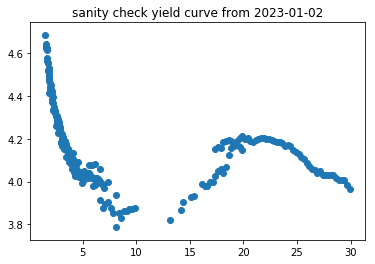

In [10]:
# sanity check last available day's yield curve
test_date = '2023-01-02'
plt.scatter(tenor_df.loc[test_date], yields_df_valid.loc[test_date])
plt.title('sanity check yield curve from %s' % test_date)

## now we build a spline curve

- for my approach, I used a simple cubic polynomial to fit the yield curve at each day
- this is a very simplisitic approach; if given more time I would put more weighting on the on-the-run cusips, as well as build the yield curve using duration as opposed to time to maturity

In [15]:
benchmark_tenors = [2, 3, 5, 7, 10, 20, 30]

benchmark_curve = []
for date in yields_df_valid.index:
    
    # look at what the yield curve is for each day
    my_data = pd.concat([tenor_df.loc[date], yields_df_valid.loc[date]], axis=1, keys=['tenor', 'yield'])
    my_data = my_data.groupby('tenor').mean().reset_index()
    
    # fit a cubic polynomial to the yield curve
    spline_curve = interpolate.splrep(my_data['tenor'], my_data['yield'])
    
    # interpolate the spot benchmark rates and save to a list
    benchmark_yields = interpolate.splev(benchmark_tenors, spline_curve)
    benchmark_curve.append(benchmark_yields)
benchmark_curve = pd.DataFrame(benchmark_curve, index=yields_df_valid.index, columns=benchmark_tenors)
benchmark_curve.columns = ['%sy' % x for x in benchmark_curve.columns]

In [16]:
benchmark_curve.tail()

,2y,3y,5y,7y,10y,20y,30y
2024-07-08,4.622395,4.410025,4.258906,4.238586,4.275916,4.597260,4.447914
2024-07-09,4.619453,4.404561,4.262933,4.251775,4.292961,4.615753,4.468625
2024-07-10,4.614168,4.400455,4.257343,4.242945,4.281379,4.605912,4.457811
2024-07-11,4.507439,4.293679,4.163756,4.157270,4.207163,4.541787,4.395978
2024-07-12,4.446543,4.237361,4.124717,4.127347,4.179800,4.528182,4.371302


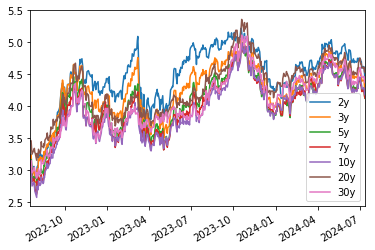

In [17]:
### spot check the yield
benchmark_curve.plot()

In [18]:
benchmark_curve.to_csv('./data/benchmark_curve.csv')